#**In this notebook we are going to experiment how to fine tune a model.**
#**Expecting to improve FLAT-T5's summarization ability with FUll Fine Tuning**
#**Save some memory as well using PEFT. Lets see how it goes :')**

> First thing first, we are going to install and load all the dependancies for our notebook.

In [ ]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
  torch==1.13.1 \
  torchdata==0.5.1 --quiet

%pip install \
  transformers==4.27.2 \
  datasets==2.11.0 \
  evaluate==0.4.0 \
  peft==0.3.0 \
  loralib==0.1.1 \
  rouge_score==0.1.2 --quiet


In [3]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import evaluate
import time
import peft
import loralib
import pandas as pd
import numpy as np
import rouge_score

> Secondly, we are taking the dataset we gonna use, in our case its dialogsum, and then we are taking our model which is flan-t5 and of course the tokenizer as well.

In [ ]:
dataset_name = 'knkarthick/dialogsum'
dataset = load_dataset(dataset_name)
dataset

In [ ]:
model_name = "google/flan-t5-base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

> Now we are going to make a function which gonna show us how many params are currently trainable out of all params.

In [6]:
def trainable_params(model):
  trainable_params = 0
  all_available_params = 0
  for name, param in model.named_parameters():
    all_available_params += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  return f"trainable_params are {trainable_params}\nand all_available_params {all_available_params}. \nThe ratio is {(trainable_params/all_available_params) * 100:.2f}%"

print(trainable_params(model))

trainable_params are 247577856
and all_available_params 247577856. 
The ratio is 100.00%


> Now we are going to do the same with these model, just writing the same code of Zero shot inference. We'll try to improve the model so that with the same thing the model gives a bit better answer.

In [7]:
index = 200
dashline = "-" * 100


dialogue = dataset['train'][index]['dialogue']
summary = dataset['train'][index]['summary']

inputs = tokenizer(dialogue, return_tensors="pt")
outputs = tokenizer.decode(model.generate(inputs["input_ids"], max_new_tokens = 100)[0], skip_special_tokens = True)


print(dashline)
print("EXAMPLE ")
print(dashline)
print("DIALOGUE")
print(dialogue)
print(dashline)
print("SUMMARY BY HUMAN")
print(summary)
print(dashline)
print("SUMMARY BY MODEL -> WITH ZERO SHOT")
print(outputs)
print(dashline)

----------------------------------------------------------------------------------------------------
EXAMPLE 
----------------------------------------------------------------------------------------------------
DIALOGUE
#Person1#: What do you want to know about me?
#Person2#: How about your academic records at college?
#Person1#: The average grade of all my courses is above 85.
#Person2#: In which subject did you get the highest marks?
#Person1#: In mathematics I got a 98.
#Person2#: Have you received any scholarships?
#Person1#: Yes, I have, and three times in total.
#Person2#: Have you been a class leader?
#Person1#: I have been a class commissary in charge of studies for two years.
#Person2#: Did you join in any club activities?
#Person1#: I was an aerobics team member in college.
#Person2#: What sport are you good at?
#Person1#: I am good at sprint and table tennis.
#Person2#: You are excellent.
---------------------------------------------------------------------------------------

> Now at this stage, we gonna preprocess the data to make it prompt-response dataset into tokens and pull put their input ids to work on *FULL FINE TUNING*. And we are going to make a function to do that for us.

In [ ]:
def tokenize_func(example):
  start_of_prompt = "Summarize the following dialogue:\n"
  end_of_prompt = "\nHere is the summarized version of the prompt:\n"
  prompt = [start_of_prompt + diag + end_of_prompt for diag in example["dialogue"]]
  example['input_ids'] = tokenizer(prompt, max_length = 1024, truncation = True, padding = "max_length", return_tensors = "pt").input_ids
  example['labels'] = tokenizer(example["summary"], max_length = 128, truncation = True, padding = "max_length", return_tensors = "pt").input_ids
  return example


tokenize_dataset = dataset.map(tokenize_func, batched = True, remove_columns = ['dialogue', 'summary', 'id', 'topic'])
tokenize_dataset['train'][0]

> So what we have done up there is;
- The example contains the dialogues
- We then create the prompt to feed into the model
- The input_ids make sures the prompt is converted into tokens and tokens doesnt go over the max limit and if short they are padded.
- Same goes for the summary.
- When we call the tokenizer it usually return input_ids and other infos. Here we only take input_ids.
- map function maps all the examples in the dataset to the function.
- We then remove all the other things from the dataset except our input_ids and labels.

In [9]:
tokenized_datasets = tokenize_dataset.filter(lambda example, index: index % 100 == 0, with_indices = True)
tokenized_datasets

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
})

> While using filter method, we can send index of anything using `with_indices = True`.

In [10]:
output_dir = f'./dialogue_summ-{str(int(time.time()))}'

training_arguments = TrainingArguments(
    output_dir = output_dir,
    # evaluation_strategy = "epoch",
    # save_strategy = "epoch",
    learning_rate = 1e-5,
    weight_decay = 0.01,
    per_device_train_batch_size = 1,
    # per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    num_train_epochs = 1,
    # save_total_limit = 3
    logging_steps = 1,
    # save_steps = 1
    # warmup_steps = 500
    fp16 = False,
    # fp16_backend = "bf16"
    # fp16_full_eval = True
    max_steps = 1
)

trainer = Trainer(
    model = model,
    args = training_arguments,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"]
)

# torch.cuda.empty_cache()

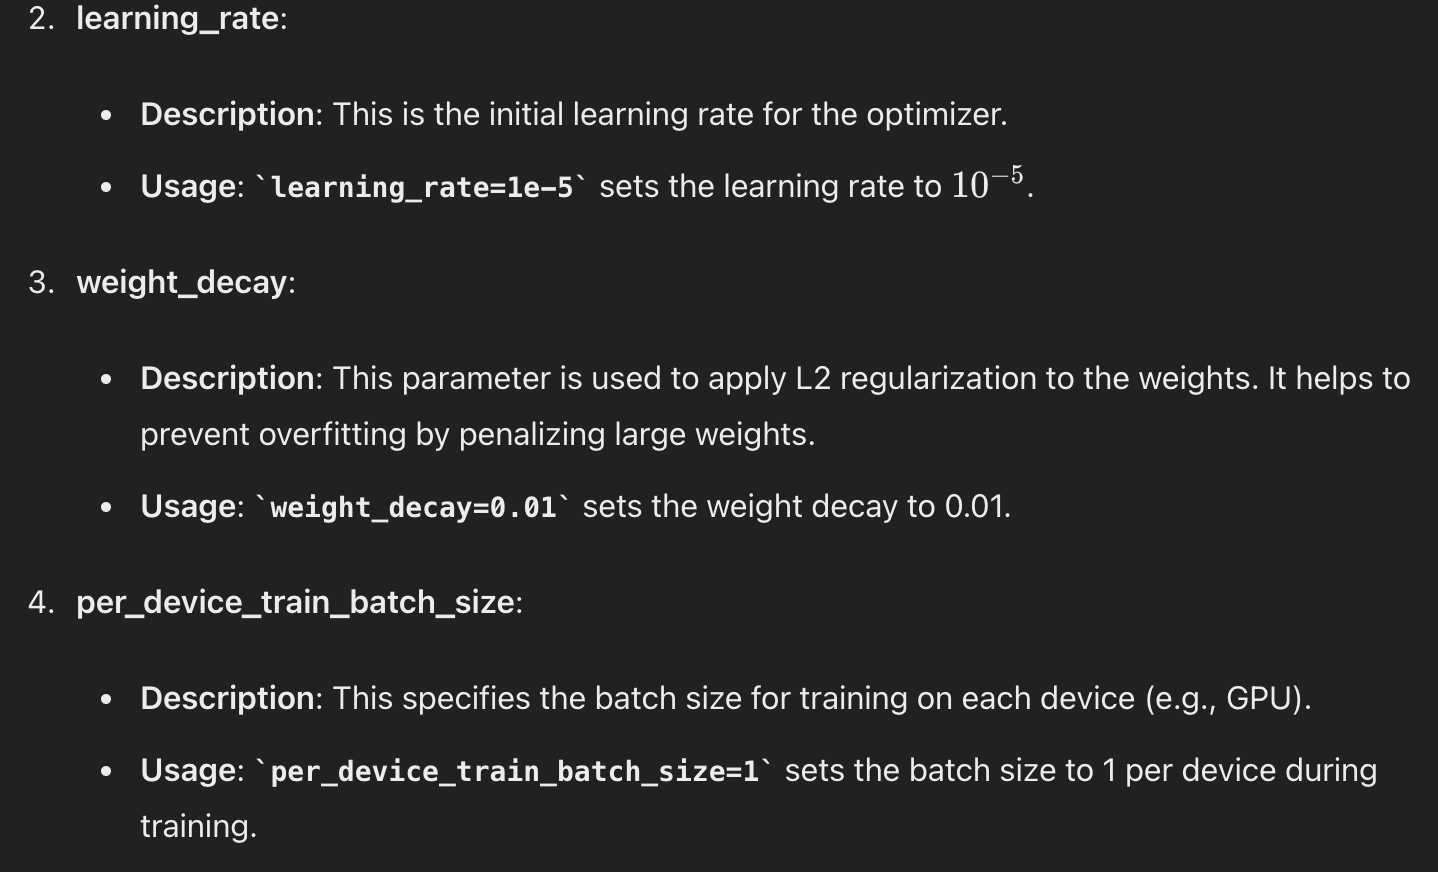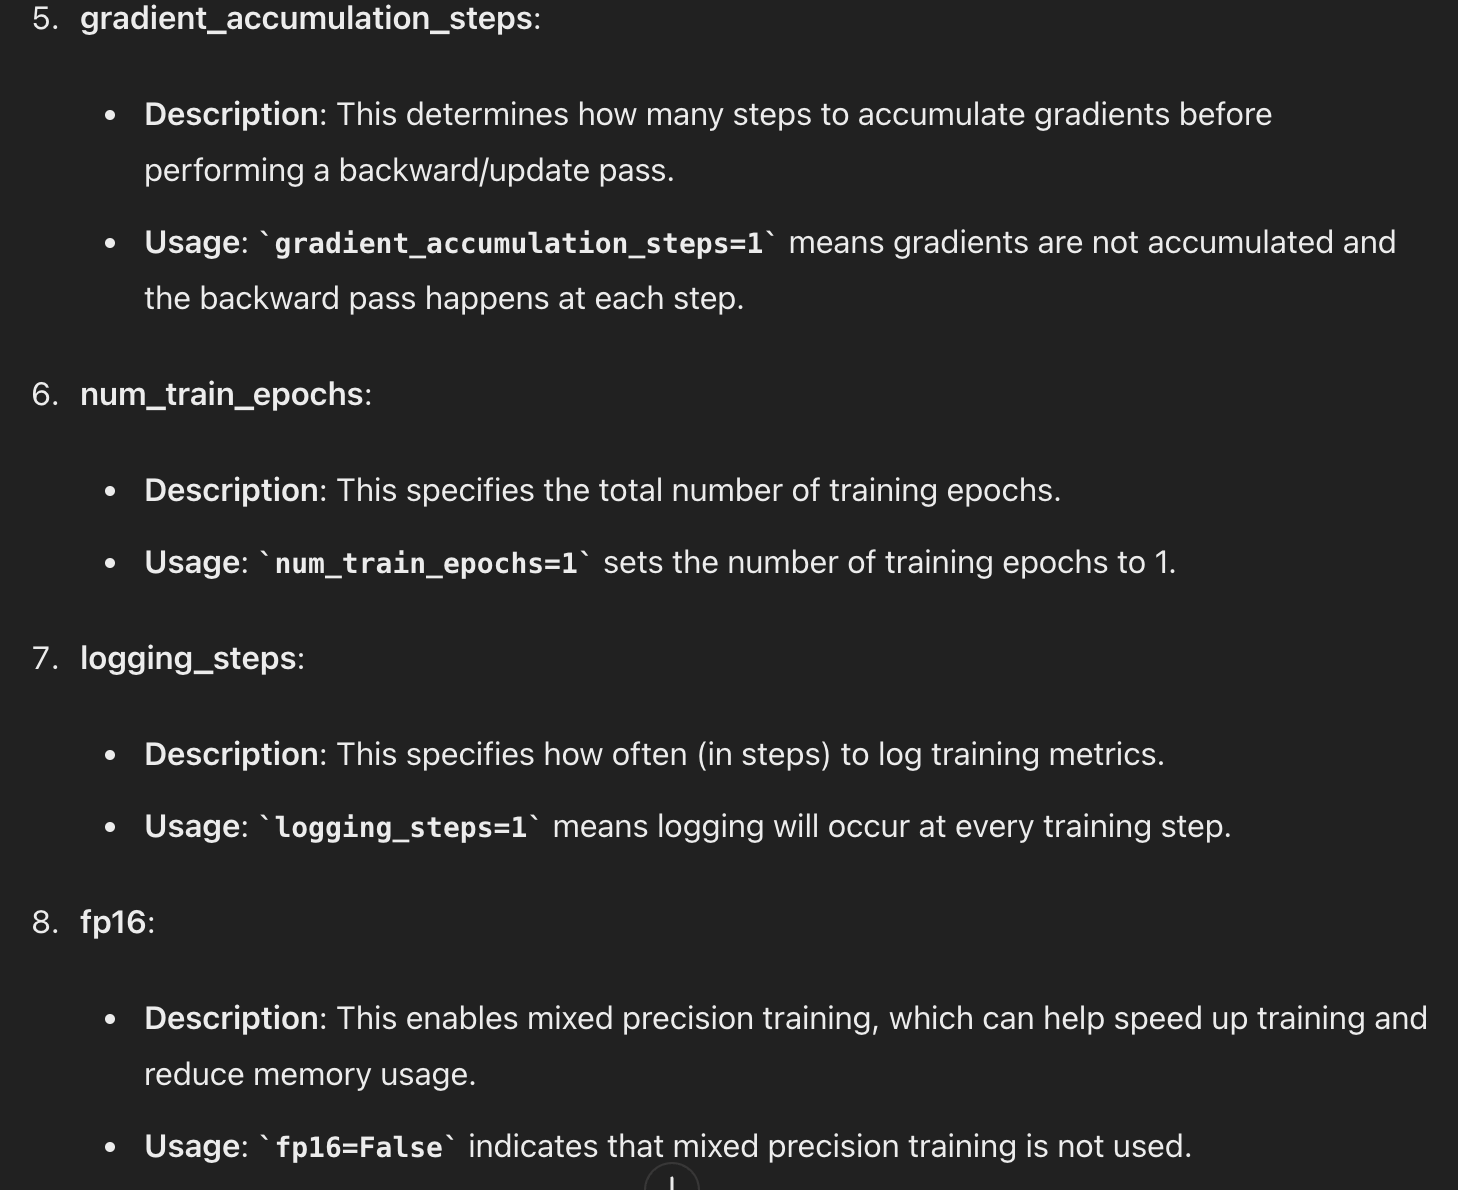

In [11]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'


> This parameter controls the maximum size (in megabytes) of a single memory chunk that PyTorch can allocate before splitting it into smaller chunks. Setting this to a lower value can help reduce fragmentation and make better use of GPU memory, especially when working with large models or datasets.

128: The value 128 means that PyTorch will attempt to allocate memory in chunks of up to 128 MB. If a request for memory exceeds this size, it will be split into smaller chunks. This can be useful in managing memory more efficiently and avoiding out-of-memory errors.

In [12]:
# !pip install torch torchvision torchaudio


In [13]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,14.250000


TrainOutput(global_step=1, training_loss=14.25, metrics={'train_runtime': 753.5534, 'train_samples_per_second': 0.001, 'train_steps_per_second': 0.001, 'total_flos': 1369514704896.0, 'train_loss': 14.25, 'epoch': 0.01})

In [14]:
trainer.save_model(output_dir)

In [15]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained(output_dir, torch_dtype = torch.bfloat16)

In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following dialogue:
{dialogue}

The summarized version of the prompt:
"""

# Move models to the correct device
model.to(device)
instruct_model.to(device)

# Tokenize the prompt and move the inputs to the correct device
inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

# Generate the outputs using the original model
original_model_outputs = model.generate(input_ids=inputs, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
original_model_test_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

# Generate the outputs using the instruction-tuned model
instruct_model_output = instruct_model.generate(input_ids=inputs, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
instruct_model_test_output = tokenizer.decode(instruct_model_output[0], skip_special_tokens=True)

# Print the results
dashline = "-" * 50
print(dashline)
print(f"EXAMPLE : {dialogue}")
print(dashline)
print(f"Baseline human summary \n: {summary}")
print(dashline)
print(f"Output by the model \n: {original_model_test_output}")
print(dashline)
print(f"Summary after fine-tuning the model \n: {instruct_model_test_output}")
print(dashline)


--------------------------------------------------
EXAMPLE : #Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.
--------------------------------------------------
Baseline human summary 
: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
------

> So above we are trying to see whats the model predicting. And here we faced a problem saying *RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!* But then we added these 2 lines to fix them ( Basically putting them in the same device ).

`` device = torch.device("cuda" if torch.cuda.is_available() else "cpu") `` <br>
` model.to(device)
instruct_model.to(device) ` <br>
`` inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device) ``

In [ ]:
# rouge = rouge_score.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge = evaluate.load("rouge")

> Here we are normally just taking the dialogues and passing through our both of the models to see how do they do comparing to our human baseline summary.

In [18]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
instruct_model.to(device)

original_model_output_list = []
instruct_model_output_list = []

for name, dialogue in enumerate(dialogues):
  prompt = f"""
Summarize the following dialogue:
{dialogue}

The summarized version of the prompt:
  """

  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
  original_model_inputs = model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
  original_model_test_output = tokenizer.decode(original_model_inputs[0], skip_special_tokens=True)
  original_model_output_list.append(original_model_test_output)

  instruct_model_summaries = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
  instruct_model_test_output = tokenizer.decode(instruct_model_summaries[0], skip_special_tokens=True)
  instruct_model_output_list.append(instruct_model_test_output)

zipped_summary = zip(human_baseline_summaries, original_model_output_list, instruct_model_output_list)
zipped_summary = list(zipped_summary)

df = pd.DataFrame(zipped_summary, columns=['human_baseline_summaries', 'original_model_test_output', 'instruct_model_test_output'])
df

,human_baseline_summaries,original_model_test_output,instruct_model_test_output
0,Ms. Dawson helps #Person1# to write a memo to ...,The Office Communication Code is now in effect.,"#Person1#: Ms. Dawson, I need you to take a di..."
1,In order to prevent employees from wasting tim...,#Person1#: This memo should go out as an intra...,"#Person1#: Ms. Dawson, I need you to take a di..."
2,Ms. Dawson takes a dictation for #Person1# abo...,#Person1#: This memo is for all employees.,"#Person1#: Ms. Dawson, I need you to take a di..."
3,#Person2# arrives late because of traffic jam....,The person who got stuck in traffic in the Car...,The person is going to take public transport t...
4,#Person2# decides to follow #Person1#'s sugges...,#Person1#: You're finally here! What took time...,The person is going to take public transport t...
5,#Person2# complains to #Person1# about the tra...,The car driver is a bad driver.,The person is going to take public transport t...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced.
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced.
8,#Person1# and Kate talk about the divorce betw...,#Person1: Masha and Hero are divorced. #Person...,Masha and Hero are getting divorced.
9,#Person1# and Brian are at the birthday party ...,Brian remembers dancing with everyone.,"#Person1#: Happy Birthday, Brian. #Person2#: I..."


In [19]:
original_model_rouge_score = rouge.compute(
    predictions = original_model_output_list,
    references = human_baseline_summaries[0:len(original_model_test_output)],
    use_stemmer = True,
    use_aggregator = True
)

instruct_model_rouge_score = rouge.compute(
    predictions = instruct_model_output_list,
    references = human_baseline_summaries[0:len(instruct_model_test_output)],
    use_stemmer = True,
    use_aggregator = True
)

print(f"Original model rouge score :\n{original_model_rouge_score}")
print(f"Instruct model rouge score :\n{instruct_model_rouge_score}")

Original model rouge score :
{'rouge1': 0.23692958788866716, 'rouge2': 0.08985559098804802, 'rougeL': 0.210524655793198, 'rougeLsum': 0.21192040695877012}
Instruct model rouge score :
{'rouge1': 0.338034990028508, 'rouge2': 0.15099926057379476, 'rougeL': 0.2776596762309788, 'rougeLsum': 0.27861950641428546}


> We tried to get the rouge score for both of the models and the parameters we used here is;
- stemmer = True -> meaning the words will be in their `root` form so that the evaluation is robust (IDK how)
- use_aggregator = True -> basically gives the mean of rouge score for the whole thing.

In [20]:
improvement = (np.array(list(instruct_model_rouge_score.values())) - np.array(list(original_model_rouge_score.values())))
for key, value in zip(instruct_model_rouge_score.keys(), improvement):
  print(f"{key} : {value*100:.2f}%")


rouge1 : 10.11%
rouge2 : 6.11%
rougeL : 6.71%
rougeLsum : 6.67%


## Now we are going to use PEFT(parameter efficient fine tuning) adapters

In [21]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 32,
    target_modules = ['q', 'v'],
    lora_dropout = 0.05,
    bias = "none",
    task_type = TaskType.SEQ_2_SEQ_LM
)

> Here we set the lora config
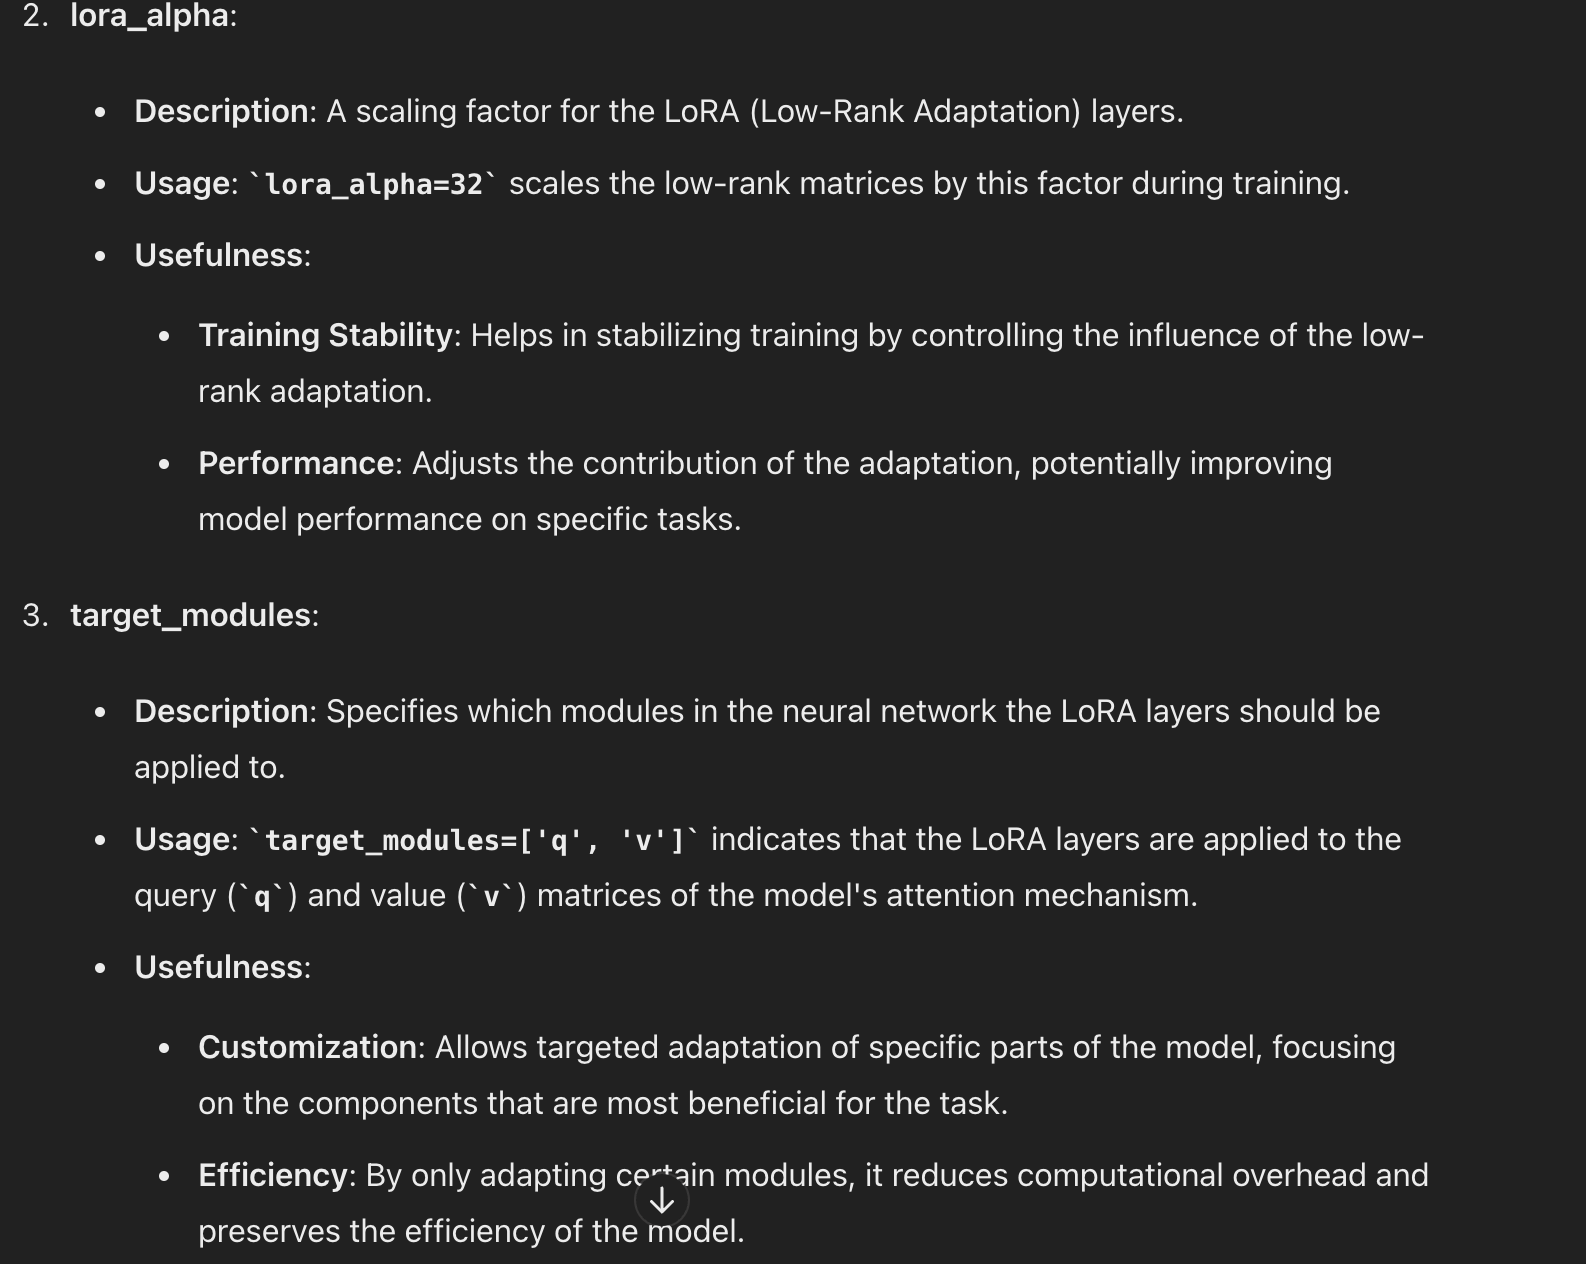

In [22]:
peft_model = get_peft_model(
    model,
    lora_config
)

print(trainable_params(peft_model))

trainable_params are 3538944
and all_available_params 251116800. 
The ratio is 1.41%


In [23]:
output_dirr = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_arguments = TrainingArguments(
    output_dir = output_dir,
    auto_find_batch_size = True,
    learning_rate = 1e-3,
    logging_steps = 1,
    num_train_epochs = 3,
    max_steps = 1
)

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_arguments,
    train_dataset = tokenized_datasets["train"]
)

In [ ]:
peft_trainer.train()
peft_model_path = "./peft-dialogue-summary-checkpoint"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


> Same thing as before, here we train and save the model.

In [ ]:
from peft import PeftModel, PeftConfig

peft_base_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_base_model,
                                       peft_model_path,
                                       torch_dtype = torch.bfloat16,
                                       is_trainable = False)

In [ ]:
print(trainable_params(peft_model))

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following dialogue:
{dialogue}

The summarized version of the prompt:
"""

# Move models to the correct device
model.to(device)
instruct_model.to(device)

# Tokenize the prompt and move the inputs to the correct device
inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

# Generate the outputs using the original model
original_model_outputs = model.generate(input_ids=inputs, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
original_model_test_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

# Generate the outputs using the instruction-tuned model
instruct_model_output = instruct_model.generate(input_ids=inputs, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
instruct_model_test_output = tokenizer.decode(instruct_model_output[0], skip_special_tokens=True)

peft_model_output = peft_model.generate(input_ids=inputs, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
peft_model_test_output = tokenizer.decode(peft_model_output[0], skip_special_tokens=True)

# Print the results
dashline = "-" * 50
print(dashline)
print(f"EXAMPLE : {dialogue}")
print(dashline)
print(f"Baseline human summary \n: {summary}")
print(dashline)
print(f"Output by the model \n: {original_model_test_output}")
print(dashline)
print(f"Summary after fine-tuning the model \n: {instruct_model_test_output}")
print(dashline)
print(f"Summary after PEFTing the model \n: {peft_model_test_output}")
print(dashline)


In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
instruct_model.to(device)

original_model_output_list = []
instruct_model_output_list = []
peft_model_output_list = []

for name, dialogue in enumerate(dialogues):
  prompt = f"""
Summarize the following dialogue:
{dialogue}

The summarized version of the prompt:
  """

  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
  original_model_inputs = model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
  original_model_test_output = tokenizer.decode(original_model_inputs[0], skip_special_tokens=True)
  original_model_output_list.append(original_model_test_output)

  instruct_model_summaries = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
  instruct_model_test_output = tokenizer.decode(instruct_model_summaries[0], skip_special_tokens=True)
  instruct_model_output_list.append(instruct_model_test_output)

  peft_model_summaries = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=100, num_beams=1, temperature=0.5))
  peft_model_test_output = tokenizer.decode(peft_model_summaries[0], skip_special_tokens=True)
  peft_model_output_list.append(peft_model_test_output)

zipped_summary = zip(human_baseline_summaries, original_model_output_list, instruct_model_output_list, peft_model_output_list)
zipped_summary = list(zipped_summary)

df = pd.DataFrame(zipped_summary, columns=['human_baseline_summaries', 'original_model_test_output', 'instruct_model_test_output', 'peft_model_test_output'])
df

In [ ]:
original_model_rouge_score = rouge.compute(
    predictions = original_model_output_list,
    references = human_baseline_summaries[0:len(original_model_test_output)],
    use_stemmer = True,
    use_aggregator = True
)

instruct_model_rouge_score = rouge.compute(
    predictions = instruct_model_output_list,
    references = human_baseline_summaries[0:len(instruct_model_test_output)],
    use_stemmer = True,
    use_aggregator = True
)

peft_model_rouge_score = rouge.compute(
    predictions = peft_model_output_list,
    references = human_baseline_summary[0:len(peft_model_output_list)],
    use_stemmer = True,
    use_aggregator = True
)

print(f"Original model rouge score :\n{original_model_rouge_score}")
print(f"Instruct model rouge score :\n{instruct_model_rouge_score}")
print(f"PEFT model rouge score :\n{peft_model_rouge_score}")

In [ ]:
improvement = (np.array(list(peft_model_rouge_score.values())) - np.array(list(original_model_rouge_score.values())))
for key, value in zip(peft_rouge_score.keys(), improvement):
  print(f"{key} : {value*100:.2f}%")

In [ ]:
improvement = (np.array(list(instruct_model_rouge_score.values())) - np.array(list(peft_model_rouge_score.values())))
for key, value in zip(peft_rouge_score.keys(), improvement):
  print(f"Difference between instruct and peft model {key} : {value*100:.2f}%")